<a href="https://colab.research.google.com/github/s017274/HOFPrediction/blob/main/Linear_Regression_Project_Correlation_of_batting_stats_to_HoF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Linear Regression for HOF Prediction**

This project, originally built for an assignment for Tom Swope's AI & Machine Learning elective at Lower Merion High School uses [Sean Lahman's "The History of Baseball" data set](https://www.kaggle.com/seanlahman/the-history-of-baseball) (specifically batting.csv and hall_of_fame.csv) to train a model that predicts which players will be inducted into the National Baseball Hall of Fame.

**Data Manipulation**

Prior to working with the pred_hof.csv file in this notebook, I created that file from Sean Lahman's data in R. My work is contained in this R Markdown file: [file:///Users/benwarren/ClassWork/pred_hof-setup.html](file:///Users/benwarren/ClassWork/pred_hof-setup.html)

Set-up

In [1]:
#Installs
!pip install -q sklearn
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
#Imports
from __future__ import absolute_import, division, print_function, unicode_literals

import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from collections import defaultdict 

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

from google.colab import files

**Process:**
1. Load Data
2. Visualize Data
3. Determine Question
4. Prepare Data
5. Build, Train, and Test Model
6. Make Predictions

**1. Load Data**

*   pred_hof.csv file is loaded after pre-processing in R
*   Necessary replacements are made (in hof column, strings for "Yes" and "No" (as "N" and "Y") are converted to 1 and 0, NaN is replaced by 0.0.
* Testing and training data is split using an sklearn function.
*Evaluation vectors are created using the "inducted" column of the data set, since the program is designed to predict a 1 or 0 in that column (whether or not the player was inducted into the Hall of Fame).



In [18]:
dfbatting = pd.read_csv('pred_hof.csv')

dfbatting = dfbatting.set_index("player_id")
dfbatting = dfbatting.replace("N", 0)
dfbatting = dfbatting.replace("Y", 1)
dfbatting = dfbatting.replace(np.NaN, 0.0)

newdf, dfeval = sklearn.model_selection.train_test_split(dfbatting, test_size = .4)

hallOfFamedf = newdf.filter(['inducted'])
y_eval = dfeval.filter(['inducted'])

newdf.head()

,g,ab,r,h,double,triple,hr,rbi,sb,bb,so,inducted
player_id,,,,,,,,,,,,
leachfr01,991,3733.0,543.0,1147.0,196.0,53.0,72.0,509.0,32.0,163.0,189.0,0
clarkjo01,546,1974.0,254.0,432.0,73.0,26.0,24.0,232.0,0.0,81.0,382.0,1
murraed02,3026,11336.0,1627.0,3255.0,560.0,35.0,504.0,1917.0,110.0,1333.0,1516.0,1
coopemo01,297,654.0,50.0,127.0,16.0,0.0,6.0,68.0,0.0,23.0,118.0,0
dickebi01,1789,6300.0,930.0,1969.0,343.0,72.0,202.0,1209.0,37.0,678.0,289.0,0


**2. Visualize Data**


* Distribution of games played
* Bar plots of games, at-bats, home runs
* Scatter plot of games vs. home runs
* Bar plot comparing Hall of Fame vs. no.
* Scatter matrix of important statistics





Histogram showing the distribution of games played and hits.

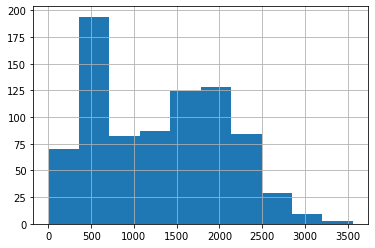

In [19]:
newdf.g.hist()

Multiple bar plot comparing the Games, ABs, and HRs of the first 10 players in the data set

<Figure size 432x288 with 0 Axes>

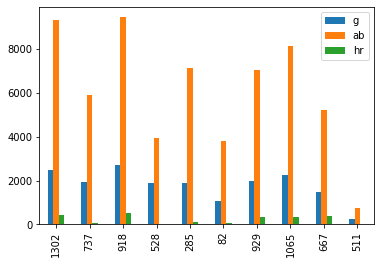

In [5]:
plotdf = newdf.iloc[:10]
plotdf = plotdf.filter(['g', 'ab', 'hr'])
plt.figure()
plotdf.plot.bar()


Scatter Plot of Home Runs hit vs. Games Played

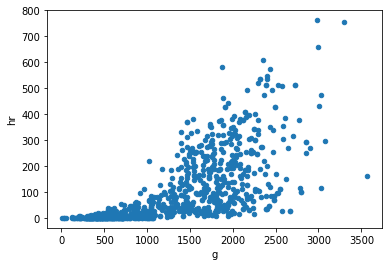

In [6]:
newdf.plot(x = 'g', y = 'hr', kind = 'scatter')

Bar graph that shows the very few players inducted into the hall of fame

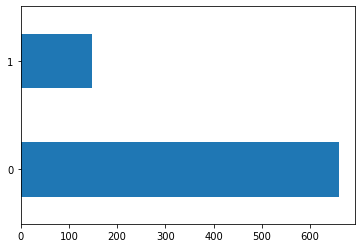

In [7]:
hallOfFamedf.inducted.value_counts().plot(kind='barh') 

Scatter Matrix of a sample of important statistics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ec4a58690>,
      dtype=object)

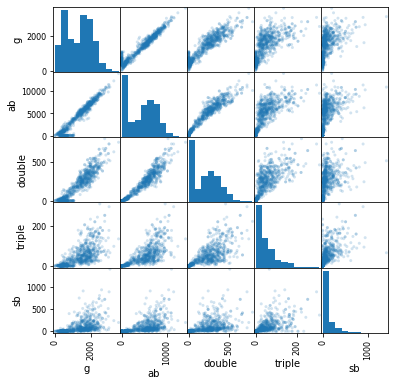

In [8]:
from pandas.plotting import scatter_matrix

plotdf = newdf.filter(['g', 'ab', 'double', 'triple', 'sb'])
scatter_matrix(plotdf, alpha=0.2, figsize=(6, 6))

**2. Determine Question**

* How accurately can a linear regression model predict 
whether or not a player will make it into the Hall of Fame based on his batting statistics? 

* My prediction is that data fields that have the highest correlation will be Games (since length of career is important for the HoF), Home Runs (because a certain amount of Home Runs is almost a guarantor of success), and Hits (similar to Home Runs).



**3. Prepare your data**
*   Set up feature columns (all numeric statistics)
*   Define and run input function for regression (choose # of epochs)



In [20]:
#Setting up feature columns
NUMERIC_COLUMNS = ['g',	'ab',	'r', 'h',	'double',	'triple',	'hr',	'rbi',	'sb', 'bb', 'so']
feature_columns = []
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))


In [21]:
#Process data to train regression model
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(newdf, hallOfFamedf, num_epochs = 15)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)


**4. Build, test, train the model**
* Use the tensorflow linear classifier with the intended feature columns to train the model.
* Print the resulting accuracy
* Current model only returns 82% accuracy on training data



In [23]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on testing data

clear_output()  # clears console output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.81146026


**5. Make Predictions**

* I am using the linear regression model to predict which players from the test data will make the Hall of Fame. In the Output, the success rate is how accurate the model's predictions were, and the list of players is all the names the model predicted would make the hall of fame, and whether or not they did (If there is a 1.0 before the name, they did, if their is a 0.0, they did not).

In [66]:
#Result of the linear regression prediction
result = list(linear_est.predict(eval_input_fn))
clear_output()

#Reduced dimensionality to just include player_id and probabilities
output = [(name, result[testList.index(name)]['probabilities']) for name in testList]

#Create y_pred vector (predicts 'inducted'= 'yes' if probability > 0.9)
y_pred = []
for item in output:
  if item[1][1] > 0.9:
    y_pred.append(1)
  else:
    y_pred.append(0)

#Prints success rate at predicting 'inducted' on test data
correct = 0
for i in range(len(y_pred)):
  if y_pred[i] == y_eval['inducted'][i]:
    correct+=1

print("Success Rate: " + str(float(correct)/len(y_pred)))


#Confusion Matrix for predictions:
print("Confusion Matrix")
sklearn.metrics.confusion_matrix(y_eval['inducted'], y_pred)


# Prints a description of a data point
# print(dfeval.loc['cronijo01'])
# Prints the induction outcome
# print(y_eval.loc['cronijo01'])
# Prints what the model predicts the probability as
# print(result[1]['probabilities'])

Success Rate: 0.8114602587800369
Confusion Matrix


array([[427,  26],
       [ 76,  12]])